## imports

In [1]:
import lenstronomy

lenstronomy.__version__

In [2]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import gc

from lenstronomy.Util import util
from lenstronomy.Util import param_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image

import paperfig as pf
pf.set_fontscale(2.)

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


In [3]:
gc.collect()

21

In [4]:
savefig = False

In [5]:
import sys
sys.path.insert(0, './process_output')

# load necessary functions for BIC computation and unpickling composite model outputs
from output_class import *

# load output files

## load power-law model chains and process

In [6]:
powerlaw_files = [
    '2038_run145_0_0_0_0_0_shortened',
    '2038_run221_0_0_0_0_0',
    '2038_run225_0_0_0_0_0',
    '2038_run227_0_0_0_0_0',
    '2038_run231_0_0_0_0_0',
    #'2038_run232_0_0_0_0_0',
    '2038_run238_0_0_0_0_0',
    '2038_run239_0_0_0_0_0',
    '2038_run240_0_0_0_0_0',
]

In [7]:
powerlaw_bics = []
powerlaw_param_arrays = []
powerlaw_num_param_arrays = []
powerlaw_kwargs_models = []
powerlaw_kwargs_constraints = []
powerlaw_param_classes = []
powerlaw_lens_models = []
powerlaw_kwargs_likelihoods = []
powerlaw_multi_band_list = []

for job_name_out in powerlaw_files:
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    fitting_kwargs_list, kwargs_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
  
    kwargs_result, multi_band_list_out, fit_output, _ = output_
    multi_band_list = kwargs_joint['multi_band_list']

    samples_mcmc = fit_output[-1][1] #[np.random.randint(0, high=fit_output[-1][1].shape[0], size=N_sample)]
    param_mcmc = fit_output[-1][2]
    
    param_class = Param(kwargs_model,
                        kwargs_params['lens_model'][2], 
                        kwargs_params['source_model'][2],
                        kwargs_params['lens_light_model'][2],
                        kwargs_params['point_source_model'][2],
                        kwargs_lens_init=kwargs_params['lens_model'][0], #kwargs_result['kwargs_lens'],
                        **kwargs_constraints
                       )
    
    lens_model = LensModel(lens_model_list=kwargs_model['lens_model_list'],
                           z_lens=0.230, z_source=0.777,
                           multi_plane=False, #True, 
                          )
    
    num_data = np.sum([np.sum(m) for m in kwargs_likelihood['image_likelihood_mask_list']])
    num_param = param_class.num_param()[0] + param_class.num_param_linear()
    max_logL = None #np.max(fit_output[-1][-1])
    
    bic = None #compute_BIC(num_data, num_param, max_logL)
    
    powerlaw_bics.append(bic)
    powerlaw_param_arrays.append(np.copy(samples_mcmc))
    powerlaw_num_param_arrays.append(len(samples_mcmc))
    powerlaw_kwargs_models.append(kwargs_model)
    powerlaw_kwargs_constraints.append(kwargs_constraints)
    powerlaw_param_classes.append(param_class)
    powerlaw_lens_models.append(lens_model)
    powerlaw_kwargs_likelihoods.append(kwargs_likelihood)
    powerlaw_multi_band_list.append(multi_band_list_out)
    
    gc.collect()
    #break

In [8]:
powerlaw_num_param_arrays

[10000, 408000, 408000, 408000, 408000, 408000, 408000, 408000]

In [9]:
powerlaw_param_arrays[1].shape

(408000, 51)

In [10]:
powerlaw_theta_es = [] # the circularly averaged one
powerlaw_theta_es_elliptical = [] # the parameter that is sampled directly
powerlaw_gammas = []  # the circularly averaged one
powerlaw_gammas_elliptical = [] # the parameter that is sampled directly

powerlaw_gamma_exts = []
powerlaw_psi_exts = []
powerlaw_reffs = []
powerlaw_qs = []
powerlaw_pas = []

powerlaw_dphi_ABs = []
powerlaw_dphi_ACs = []
powerlaw_dphi_ADs = []

powerlaw_invariant_gradients = [] # at circular averaged theta_E
powerlaw_invariant_gradients_ellipticals = [] # at sampled theta_E

#powerlaw_del_bics = np.max(powerlaw_bics) - np.array(powerlaw_bics)
#powerlaw_weights = get_relative_weights(powerlaw_bics, 0., take_std=False, sigma_model=np.std(powerlaw_bics)) #np.exp(powerlaw_del_logZs) / np.sum(np.exp(powerlaw_del_logZs))
powerlaw_weights = [1.] * len(powerlaw_files)

#print(powerlaw_weights)
N_sample = 100

for n_job in tnrange(len(powerlaw_files), desc='Jobs:'):
    
    powerlaw_theta_e = []
    powerlaw_theta_e_elliptical = []
    powerlaw_theta_e_precision = []
    powerlaw_gamma = []
    powerlaw_gamma_elliptical = []
    powerlaw_gamma_ext = []
    powerlaw_psi_ext = []
    powerlaw_reff = []
    powerlaw_q, powerlaw_phi = [], []

    powerlaw_dphi_AB = []
    powerlaw_dphi_AC = []
    powerlaw_dphi_AD = []
    powerlaw_invariant_gradient = []
    powerlaw_invariant_gradient_elliptical = []
    
    num_sample_from_job = int(powerlaw_weights[n_job] * powerlaw_num_param_arrays[n_job])
    
    td_cosmography = TDCosmography(z_lens=0.230, z_source=0.777, kwargs_model=powerlaw_kwargs_models[n_job])
    
    sampled_indices = np.random.randint(low=powerlaw_num_param_arrays[n_job]-5000, high=powerlaw_num_param_arrays[n_job], size=N_sample)
    
    lens_model = powerlaw_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(powerlaw_lens_models[n_job])
  
    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
        param_array = powerlaw_param_arrays[n_job][sampled_indices[i]]

        param_class = powerlaw_param_classes[n_job]
        
        kwargs_result = param_class.args2kwargs(param_array)
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']

        model_bool = [False] * len(lens_result)
        model_bool[0] = True
        #model_bool[2] = False # True for composite
        model_index = [0] #[0, 2] for composite
        
#         powerlaw_theta_e.append(lens_result[0]['theta_E'])
#         powerlaw_gamma.append(lens_result[0]['gamma'])
        
#         theta_e, prec = lens_analysis.effective_einstein_radius(lens_result, model_bool_list=model_index,
#                                                          grid_spacing=0.015, get_precision=True)
#         theta_e += np.random.normal(loc=0., scale=prec)
        
#         powerlaw_theta_e.append(theta_e)
        powerlaw_theta_e_elliptical.append(lens_result[0]['theta_E'])
        powerlaw_gamma_elliptical.append(lens_result[0]['gamma'])
        
#         powerlaw_gamma.append(lens_analysis.profile_slope(lens_result, theta_e))
        
#         shear_psi, shear_mag = param_util.shear_cartesian2polar(lens_result[1]['gamma1'],
#                                                                 lens_result[1]['gamma2'],
#                                                                )
        
#         phi, q = param_util.ellipticity2phi_q(lens_result[0]['e1'],
#                                               lens_result[0]['e2'])
#         powerlaw_q.append(q)
#         powerlaw_phi.append(phi*180/np.pi)
        
#         powerlaw_gamma_ext.append(shear_mag)
#         powerlaw_psi_ext.append(shear_psi*180/np.pi)


#         fermat_potential = td_cosmography.fermat_potential(lens_result, ps_result, original_ps_position=True)
        
#         dphi_AB = fermat_potential[1] - fermat_potential[3]
#         dphi_AC = fermat_potential[1] - fermat_potential[2]
#         dphi_AD = fermat_potential[1] - fermat_potential[0]
        
#         powerlaw_dphi_AB.append(dphi_AB)
#         powerlaw_dphi_AC.append(dphi_AC)
#         powerlaw_dphi_AD.append(dphi_AD)
        
#         powerlaw_invariant_gradient.append(lens_analysis.mst_invariant_differential(lens_result, theta_e))
#         powerlaw_invariant_gradient_elliptical.append(lens_analysis.mst_invariant_differential(lens_result, lens_result[0]['theta_E']))
        
    powerlaw_theta_es.append(powerlaw_theta_e)
    powerlaw_theta_es_elliptical.append(powerlaw_theta_e_elliptical)
    powerlaw_gammas.append(powerlaw_gamma)
    powerlaw_gammas_elliptical.append(powerlaw_gamma_elliptical)
    powerlaw_qs.append(powerlaw_q)
    powerlaw_pas.append(powerlaw_phi)
    powerlaw_dphi_ABs.append(powerlaw_dphi_AB)
    powerlaw_dphi_ACs.append(powerlaw_dphi_AC)
    powerlaw_dphi_ADs.append(powerlaw_dphi_AD)
    powerlaw_gamma_exts.append(powerlaw_gamma_ext)
    powerlaw_psi_exts.append(powerlaw_psi_ext)
    powerlaw_invariant_gradients.append(powerlaw_invariant_gradient)
    powerlaw_invariant_gradients_ellipticals.append(powerlaw_invariant_gradient_elliptical)

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Jobs::   0%|          | 0/8 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Sample from job 0::   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Sample from job 1::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 2::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 3::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 4::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 5::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 6::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 7::   0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
from getdist import plots
from getdist import MCSamples
import matplotlib.pyplot as plt
import matplotlib.colors as col
import paperfig as pf

In [12]:
%matplotlib inline

pl_samples_list = []

for k in range(5):
    pl_samples = np.array([powerlaw_theta_es_elliptical[k],
                           powerlaw_gammas[k],
                           powerlaw_gamma_exts[k],
                           powerlaw_psi_exts[k],
                           powerlaw_invariant_gradients[k],
                           #powerlaw_dphi_ABs[k],
                           #powerlaw_dphi_ACs[k],
                           #powerlaw_dphi_ADs[k],
                           #powerlaw_Ds_Ddss[k][np.random.randint(0, high=len(powerlaw_Ds_Ddss[k]), size=len(powerlaw_theta_es[k]))]
                          ])
#     if k == 0:
#         gamma = np.mean(pl_samples[1])
#         mean_dphi_AB = np.mean(pl_samples[5])
#         mean_dphi_AC = np.mean(pl_samples[6])
#         mean_dphi_AD = np.mean(pl_samples[7])
#         #mean_DsDds = np.mean(pl_samples[7])

#     pl_samples[1] = pl_samples[1]/gamma - 1.
#     pl_samples[5]  = pl_samples[5]/mean_dphi_AB - 1.
#     pl_samples[6]  = pl_samples[6]/mean_dphi_AC - 1.
#     pl_samples[7]  = pl_samples[7]/mean_dphi_AD - 1.
    #pl_samples[7]  = pl_samples[7]/mean_DsDds - 1.

    print('Chain shape:', np.array(pl_samples).shape)#, np.array(comp_samples).shape)
    
    pl_samples_list.append(MCSamples(samples=np.array(pl_samples).T, 
                          names=['theta_E', 
                                 'gamma', 
                                 'gamma_ext', 'psi_ext', 'invariant_grad',
                                 #'dphi_AB', 'dphi_AC', 'dphi_AD', #'DsDds'
                                ], 
                          labels=['{\\theta}_{\\rm{E}}', 
                                  '\\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                  '\\gamma_{\\rm{ext}}', 
                                  '\\psi_{\\rm{ext}} {\\rm\ (deg)}',
                                  '\\xi_{\\rm rad}',
                                  #'{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                  #'{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                  #'{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                  #'{\\rm blinded}\\ D_{\\rm s}/D_{\\rm ds}'
                                 ],
                      ))
    pl_samples_list[-1].updateSettings({'smooth_scale_2D': 0.7})
    
    
pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 16
g.settings.lab_fontsize = 18
g.settings.legend_fontsize = 18

g.triangle_plot(pl_samples_list,
                contour_lws=[1.]*12, 
                contour_ls=['-']*12, #+ ['--']*12,
                legend_labels=['lenstronomy baseline', 'Glee PSFs', 'lenstronomy PSFs UVIS', 'Glee PSFs UVIS',
                               'lenstronomy IR supersampled', 'lenstronomy IR supersampled'
                              ],
                
               )

# '2038_run145_0_0_0_0_0_shortened',
#     '2038_run221_0_0_0_0_0',
#     '2038_run225_0_0_0_0_0',
#     '2038_run227_0_0_0_0_0',
#     '2038_run231_0_0_0_0_0',
#     #'2038_run232_0_0_0_0_0',
#     '2038_run238_0_0_0_0_0',
    
#g.fig.tight_layout()

Chain shape: (5,)
Removed no burn in


/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


ValueError: operands could not be broadcast together with shapes (100,) (0,) 

## Compare with Glee

In [13]:
# from https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [15]:
output_files = ['../../glee_outputs/2038_pl_fid_3band_glee.csv',
                '../../glee_outputs/2038_pl_fid_3band_lenstronomypsf.csv',
                '../../glee_outputs/2038_pl_fid_3band_lenstronomypsf_psferrmap.csv',
                '../../glee_outputs/2038_pl_fid_uvis_lenstronomypsf.csv',
                '../../glee_outputs/2038_pl_fid_3band_lenstronomypsf_psferrmap.csv'
               ]

glee_fiducial_gamma = None
glee_lenstronomy_psf_gamma = None
glee_lenstronomy_psf_error_map_gamma = None
glee_fiducial_uvis_gamma = None
glee_lenstronomy_hires_uvis_gamma = None

glee_gammas = [glee_fiducial_gamma, glee_lenstronomy_psf_gamma, 
               glee_lenstronomy_psf_error_map_gamma, glee_fiducial_uvis_gamma,
               glee_lenstronomy_hires_uvis_gamma
              ]

for i, output_file in enumerate(output_files):
    glee_params = np.genfromtxt(output_file, skip_header=1, delimiter=',')
    glee_gammas[i] = glee_params[np.random.choice(
                    np.arange(glee_params.shape[0]), size=1000, p=glee_params[:, 0]/np.sum(glee_params[:, 0])
                ), 4]


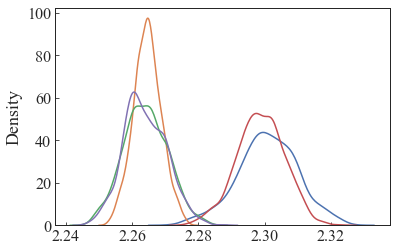

In [16]:
import seaborn as sns

for glee_gamma in glee_gammas:
    #sns.kdeplot(glee_fiducial[:, 4])
    sns.kdeplot(glee_gamma)

In [17]:
#     '2038_run145_0_0_0_0_0_shortened',
#     '2038_run221_0_0_0_0_0',
#     '2038_run225_0_0_0_0_0',
#     '2038_run227_0_0_0_0_0',
#     '2038_run231_0_0_0_0_0',
#     '2038_run238_0_0_0_0_0',
#     '2038_run239_0_0_0_0_0',
    
output_files

['../../glee_outputs/2038_pl_fid_3band_glee.csv',
 '../../glee_outputs/2038_pl_fid_3band_lenstronomypsf.csv',
 '../../glee_outputs/2038_pl_fid_3band_lenstronomypsf_psferrmap.csv',
 '../../glee_outputs/2038_pl_fid_uvis_lenstronomypsf.csv',
 '../../glee_outputs/2038_pl_fid_3band_lenstronomypsf_psferrmap.csv']

In [18]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


In [19]:
def gs(arr1, arr2):
    #m1, s1 = np.mean(arr1), np.std(arr1)
    #m2, s2 = np.mean(arr2), np.std(arr2)
    l1, m1, h1 = np.percentile(arr1, q=[16, 50, 84])
    l2, m2, h2 = np.percentile(arr2, q=[16, 50, 84])
    
    s1 = (h1 - l1)/2.
    s2 = (h2 - l2)/2.
    
    return np.abs(m1 - m2) / np.sqrt(s1**2 + s2**2), np.abs(m1 - m2) / max(m1, m2) * 100

(2.352812658460554, 1.383218170791478)
(1.0470975781739358, 0.7760824759430016)
(2.1390409343513888, 1.3534660569776191)
(0.9290274200514921, 0.6138770304652257)
(4.500802275938437, 2.8479927087424244)
(0.5468178100534677, 0.7083187850491186)
(0.8338024892382447, 0.5302929727335131)
(2.141498546330845, 1.3391653183035759)
(3.1862766032369856, 2.1505863040280735)
(4.428832046105367, 2.946282673649635)


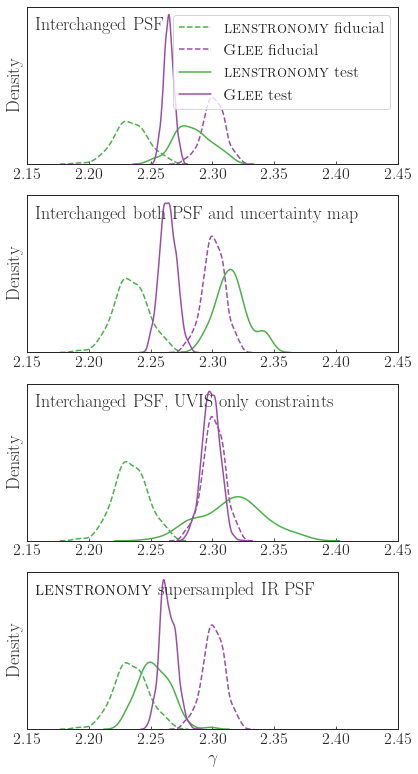

In [22]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_colwidth*2, height_ratio=2))

pf.set_fontscale(2)

ax2 = fig.add_subplot(411)

sns.kdeplot(powerlaw_gammas_elliptical[0], ax=ax2, color=pf.cb_green, ls='--', label=r'$\textsc{lenstronomy}$ fiducial')
sns.kdeplot(glee_gammas[0], ax=ax2, color=pf.cb_purple, ls='--', label=r'$\textsc{Glee}$ fiducial')

print(gs(powerlaw_gammas_elliptical[0], glee_gammas[1]))
print(gs(glee_gammas[0], powerlaw_gammas_elliptical[1]))

sns.kdeplot(powerlaw_gammas_elliptical[1], ax=ax2, color=pf.cb_green, ls='-', label=r'$\textsc{lenstronomy}$ test')
sns.kdeplot(glee_gammas[1], ax=ax2, color=pf.cb_purple, ls='-', label=r'$\textsc{Glee}$ test')

ax2.set_xlim(2.15, 2.4)
ax2.text(0.02, 0.85, 'Interchanged PSF', transform=ax2.transAxes)
ax2.legend(loc='upper right')

ax3 = fig.add_subplot(412, sharex=ax2)

sns.kdeplot(powerlaw_gammas_elliptical[0], ax=ax3, color=pf.cb_green, ls='--')
sns.kdeplot(glee_gammas[0], ax=ax3, color=pf.cb_purple, ls='--')

print(gs(powerlaw_gammas_elliptical[0], glee_gammas[2]))
print(gs(glee_gammas[0], powerlaw_gammas_elliptical[7]))

sns.kdeplot(powerlaw_gammas_elliptical[7], ax=ax3, color=pf.cb_green, ls='-')
sns.kdeplot(glee_gammas[2], ax=ax3, color=pf.cb_purple, ls='-')

ax3.set_xlim(2.15, 2.4)
ax3.text(0.02, 0.85, 'Interchanged both PSF and uncertainty map', transform=ax3.transAxes)


ax1 = fig.add_subplot(413, sharex=ax2)

sns.kdeplot(powerlaw_gammas_elliptical[0], ax=ax1, color=pf.cb_green, ls='--')
sns.kdeplot(glee_gammas[0], ax=ax1, color=pf.cb_purple, ls='--')


print(gs(powerlaw_gammas_elliptical[0], glee_gammas[3]))
print(gs(glee_gammas[0], powerlaw_gammas_elliptical[2]))


sns.kdeplot(powerlaw_gammas_elliptical[2], ax=ax1, color=pf.cb_green, ls='-')
sns.kdeplot(glee_gammas[3], ax=ax1, color=pf.cb_purple, ls='-')

ax1.set_xlim(2.15, 2.4)
#ax1.legend()
ax1.text(0.02, 0.85, 'Interchanged PSF, UVIS only constraints', transform=ax1.transAxes)

ax4 = fig.add_subplot(414, sharex=ax2)

sns.kdeplot(powerlaw_gammas_elliptical[0], ax=ax4, color=pf.cb_green, ls='--')
sns.kdeplot(glee_gammas[0], ax=ax4, color=pf.cb_purple, ls='--')

#print(gs(powerlaw_gammas_elliptical[0], glee_gammas[2]))
print(gs(glee_gammas[4], powerlaw_gammas_elliptical[4]))
print(gs(glee_gammas[4], powerlaw_gammas_elliptical[0]))
print(gs(glee_gammas[0], powerlaw_gammas_elliptical[4]))

print(gs(glee_gammas[0], powerlaw_gammas_elliptical[0]))

sns.kdeplot(powerlaw_gammas_elliptical[4], ax=ax4, color=pf.cb_green, ls='-')
#sns.kdeplot(powerlaw_gammas_elliptical[5], ax=ax4, color=pf.cb_green, ls='-')
sns.kdeplot(glee_gammas[4], ax=ax4, color=pf.cb_purple, ls='-')

ax4.set_xlim(2.15, 2.4)
#ax1.legend()
ax4.text(0.02, 0.85, r'$\textsc{lenstronomy}$ supersampled IR PSF', transform=ax4.transAxes)
ax4.set_xlabel(r'$\gamma$')

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.set_xlim(2.15, 2.45)
    #ax.set_ylabel('')
    ax.set_yticks([])
    
#     if i != 3:
#         ax.set_xticklabels([])
    
# plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/psf_test_comparison.pdf', bbox_inches='tight')